In [207]:
import random
from mesa import Agent, Model, batch_run
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
import pandas as pd
import seaborn as sns
import numpy as np

class VoterAgent(Agent):
    """ An agent with a belief given some probability p"""
    def __init__(self, unique_id, model, p, cc):
        super().__init__(unique_id, model)
        self.p = p
        self.cc = cc


    # Agents vote
    def step(self):
        self.model.voteCommonCause(self.p, self.cc)


class VotingModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, p, cc):
        self.num_agents = N
        self.schedule = SimultaneousActivation(self)
        self.p = p
        self.cc = cc
        self.votes = []
        self.totalnumvotes = 0
        self.running = True


        # Create agents
        for i in range(self.num_agents + 1):  
            a = VoterAgent(i, self, p, cc)
            self.schedule.add(a)
            

        # Set up data collector
        self.datacollector = DataCollector(
            model_reporters={"Majority_Vote": lambda m: sum(m.votes) > N/2, 
                             "Total_Votes": "totalnumvotes"}
        )
        
        
    # Votes based on the common cause principle i.e P(A&B) > P(A)P(B)
    # If cc = 0, then its equivalent with the independence assumption i.e P(A&B) P(A)P(B)
    def voteCommonCause(self, p, cc):
        vote = 1 if random.random() - cc < p else 0
        self.votes.append(vote)


    def step(self):
        self.schedule.step()  # Activate all agents, each agent votes once
        self.totalnumvotes += sum(self.votes)  # Add number of votes this step to total
        self.datacollector.collect(self)  # Collect data after votes
        self.votes = []  # Clear votes after collecting data for this step

In [208]:
p = 0.51  # Probability to believe in ground truth
N = 53 # Number of individuals
cc = 0 # Common Cause factor
T = 23 # Number of times the population vote. Can be imagined that they recast their vote at each timestep, and this is how many timesteps long the simulation goes on for. 


model = VotingModel(N, p, cc)
for i in range(T):
    model.step()


data = model.datacollector.get_model_vars_dataframe()
print(data)

    Majority_Vote  Total_Votes
0           False           25
1           False           48
2            True           75
3           False          100
4            True          130
5           False          155
6            True          185
7            True          216
8           False          239
9            True          269
10          False          295
11           True          322
12           True          351
13          False          374
14          False          399
15          False          425
16           True          454
17           True          482
18           True          510
19          False          536
20          False          559
21          False          582
22           True          610


C:\Users\Katte\AppData\Local\Temp\ipykernel_16064\2814756488.py:12: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


In [209]:
params = {"N": 10, "p": np.arange(0,1.1,0.1), "cc": -0.8}

results = batch_run(
    VotingModel,
    parameters=params,
    iterations=10,
    max_steps=0,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)


results_df = pd.DataFrame(results)


  0%|          | 0/110 [00:00<?, ?it/s]

C:\Users\Katte\AppData\Local\Temp\ipykernel_16064\2814756488.py:12: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


[Text(0.5, 0, 'Probability'),
 Text(0, 0.5, 'Number of votes'),
 Text(0.5, 1.0, 'Probability vs Number of votes, 10 population size, iterated 10 times')]

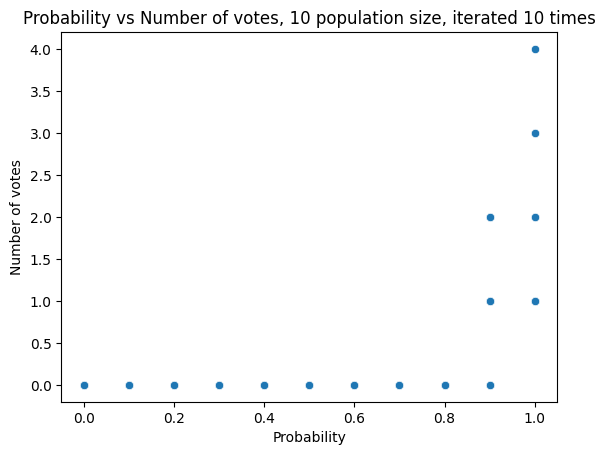

In [210]:
# Create a scatter plot
g = sns.scatterplot(data=results_df, x="p", y="Total_Votes")
g.set(
    xlabel="Probability",
    ylabel="Number of votes",
    title="Probability vs Number of votes, 10 population size, iterated 10 times",
)

In [211]:
params = {"N":np.arange(3,1001,2), "p": 0.55, "cc": 0}

results = batch_run(
    VotingModel,
    parameters=params,
    iterations=1,
    max_steps=0,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)


results_df = pd.DataFrame(results)
results_df

  0%|          | 0/499 [00:00<?, ?it/s]

C:\Users\Katte\AppData\Local\Temp\ipykernel_16064\2814756488.py:12: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


,RunId,iteration,Step,N,p,cc,Majority_Vote,Total_Votes
0,0,0,0,3,0.55,0,False,1
1,1,0,0,5,0.55,0,True,5
2,2,0,0,7,0.55,0,True,6
3,3,0,0,9,0.55,0,True,5
4,4,0,0,11,0.55,0,True,8
...,...,...,...,...,...,...,...,...
494,494,0,0,991,0.55,0,True,548
495,495,0,0,993,0.55,0,True,526
496,496,0,0,995,0.55,0,True,559
497,497,0,0,997,0.55,0,True,532


[Text(0.5, 0, 'Voters'),
 Text(0, 0.5, 'Number of votes'),
 Text(0.5, 1.0, 'Voters vs Number of votes, probability = 0.55')]

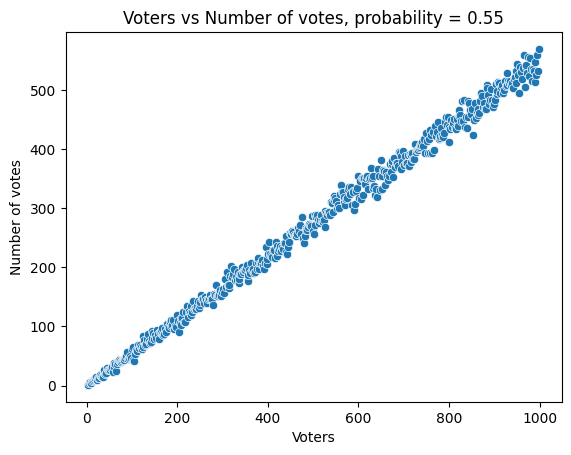

In [212]:
# Create a scatter plot
g = sns.scatterplot(data=results_df, x="N", y="Total_Votes")
g.set(
    xlabel="Voters",
    ylabel="Number of votes",
    title="Voters vs Number of votes, probability = 0.55",
)

[Text(0.5, 0, 'Number of Voters'),
 Text(0, 0.5, 'Voted truthfully (1) or voting falsly (0)'),
 Text(0.5, 1.0, 'Voters vs how they vote, probability = 0.55')]

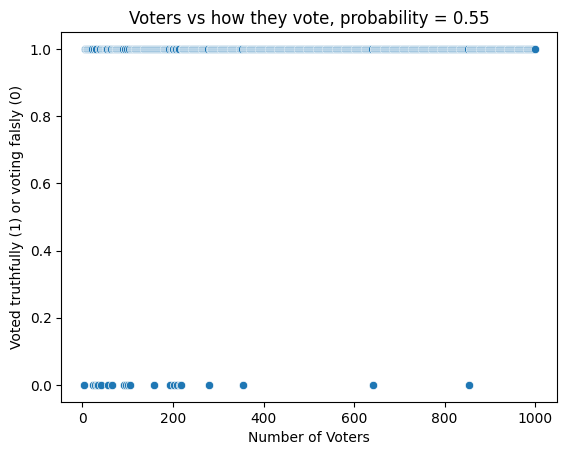

In [213]:
# Create a scatter plot
g = sns.scatterplot(data=results_df, x="N", y="Majority_Vote")
g.set(
    xlabel="Number of Voters",
    ylabel="Voted truthfully (1) or voting falsly (0)",
    title="Voters vs how they vote, probability = 0.55",
)

In [217]:
params = {"N":np.arange(3,1001,2), "p": 0.55, "cc": -0.1}

results = batch_run(
    VotingModel,
    parameters=params,
    iterations=1,
    max_steps=0,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)


results_df = pd.DataFrame(results)
results_df

  0%|          | 0/499 [00:00<?, ?it/s]

C:\Users\Katte\AppData\Local\Temp\ipykernel_16064\2814756488.py:12: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


,RunId,iteration,Step,N,p,cc,Majority_Vote,Total_Votes
0,0,0,0,3,0.55,-0.1,True,2
1,1,0,0,5,0.55,-0.1,False,2
2,2,0,0,7,0.55,-0.1,False,2
3,3,0,0,9,0.55,-0.1,False,2
4,4,0,0,11,0.55,-0.1,False,3
...,...,...,...,...,...,...,...,...
494,494,0,0,991,0.55,-0.1,False,469
495,495,0,0,993,0.55,-0.1,False,426
496,496,0,0,995,0.55,-0.1,False,459
497,497,0,0,997,0.55,-0.1,False,457


[Text(0.5, 0, 'Voters'),
 Text(0, 0.5, 'Number of votes'),
 Text(0.5, 1.0, 'Voters vs Number of votes, probability = 0.55')]

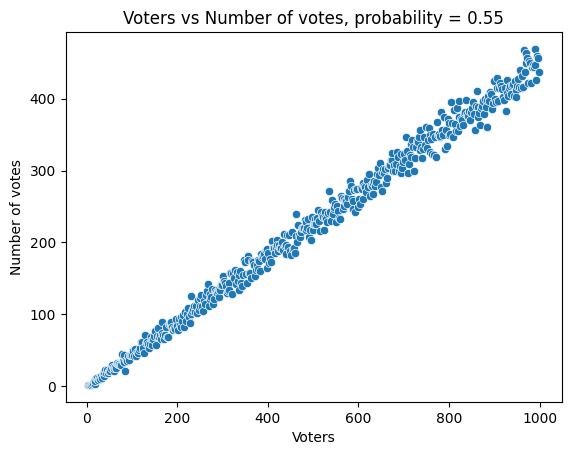

In [218]:
# Create a scatter plot
g = sns.scatterplot(data=results_df, x="N", y="Total_Votes")
g.set(
    xlabel="Voters",
    ylabel="Number of votes",
    title="Voters vs Number of votes, probability = 0.55",
)

[Text(0.5, 0, 'Number of Voters'),
 Text(0, 0.5, 'Voted truthfully (1) or voting falsly (0)'),
 Text(0.5, 1.0, 'Voters vs how they vote, probability = 0.55, cc = -0.1')]

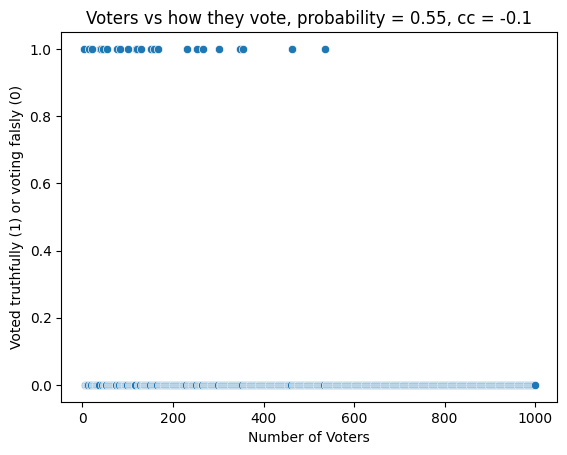

In [220]:
# Create a scatter plot
g = sns.scatterplot(data=results_df, x="N", y="Majority_Vote")
g.set(
    xlabel="Number of Voters",
    ylabel="Voted truthfully (1) or voting falsly (0)",
    title="Voters vs how they vote, probability = 0.55, cc = -0.1",
)